In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
import statsmodels.api as sm
import torch
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
pre_path = "./data/"

# Load data 


In [2]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


# Simple Momentum and Volatility Factor


In [3]:
data_df = data_df.sort_values(['coin_type','open_time']).reset_index(drop=True)

# 1) Compute simple hourly return per coin:
#    r_{t} = (close_{t} / close_{t−1}) − 1
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .pct_change()           # percent change from previous timestamp (same coin)
)

# 2) (Optional) Drop the very first row per coin where return is NaN:
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

In [4]:
L_mom  = 24    # e.g. past 24h cumulative return
L_vol  = 24    # e.g. past 24h rolling volatility (std of hourly returns)
N      =  1    # we’ll backtest next‐hour return by default


In [5]:
# (A) First, we need to make sure that for each coin, we can look back L_mom hours exactly.
#     Because data is hourly, we can do a groupby shift or a pct_change(periods=L_mom).

# 3.1) Calculate past‐L_mom simple return:
data_df['mom_raw'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda ser: ser.pct_change(periods=L_mom))
)


# 3.2) Because pct_change(periods=L_mom) will put NaN for the first L_mom rows per coin,
#      we drop those timestamps or leave them NaN and filter later.
data_df['mom_raw'] = data_df['mom_raw'].fillna(0.0)  # or leave NaN if you prefer to filter


In [6]:
# 4.1) For each coin, take rolling std of 'return' over the past L_vol hours:
data_df['vol_raw'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda r: r.rolling(window=L_vol, min_periods=1).std())
)


In [7]:
# 5.1) First build a shifted‐N forward return per coin:
data_df['fwd_ret_raw'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda ser: ser.pct_change(periods=N).shift(-N))
)

In [8]:
# 6.1) Define a helper to cross‐sectionally z‐score by timestamp:
def cross_sectional_zscore(df, column_name):
    """
    For each unique open_time, compute the z‐score of df[column_name]
    across all coins.  Return a Series of the same length.
    """
    return (
        df
        .groupby('open_time')[column_name]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )

# 6.2) Apply to 'mom_raw' and 'vol_raw':
data_df['mom_cs_z'] = cross_sectional_zscore(data_df, 'mom_raw')
data_df['vol_cs_z'] = cross_sectional_zscore(data_df, 'vol_raw')

# 6.3) If you prefer quantile‐rank instead (e.g. 0–1 rank), you could also do:
# data_df['mom_rank'] = data_df.groupby('open_time')['mom_raw'].rank(pct=True)
# data_df['vol_rank'] = data_df.groupby('open_time')['vol_raw'].rank(pct=True)
#
# But for now we’ll stick with z‐scores.


In [9]:
# 7.1) Create a DataFrame that, for each (open_time, coin_type), has:
#      - mom_cs_z
#      - fwd_ret_raw
# Then, at each open_time, pick the single highest‐mom & single lowest‐mom coin.

df_bt = data_df[['open_time','coin_type','mom_cs_z','vol_cs_z','fwd_ret_raw']].copy()

# 7.2) At each timestamp, find top‐1 coin_type by mom_cs_z, and bottom‐1 by mom_cs_z:
def tag_top_bottom(df, factor_col, top_n=1, bottom_n=1):
    """
    For each open_time group:
      - Find the top_n coin_types with highest factor_col → LONG leg
      - Find the bottom_n coin_types with lowest factor_col → SHORT leg
    Returns a DataFrame with additional columns:
      'is_long_<factor_col>' = 1 if this coin is in the LONG leg, else 0
      'is_short_<factor_col>' = 1 if coin in SHORT leg, else 0
    """
    out = df.copy()
    out[f'is_long_{factor_col}']  = 0
    out[f'is_short_{factor_col}'] = 0

    def tag_group(g):
        # g is the subset for one open_time
        # Sort by factor_col:
        g_sorted = g.sort_values(by=factor_col, ascending=False)
        # Tag long:
        long_coins  = g_sorted['coin_type'].iloc[0:top_n].values
        short_coins = g_sorted['coin_type'].iloc[-bottom_n:].values
        out_idx = g.index
        out.loc[out_idx, f'is_long_{factor_col}']  = g['coin_type'].isin(long_coins).astype(int)
        out.loc[out_idx, f'is_short_{factor_col}'] = g['coin_type'].isin(short_coins).astype(int)
        return

    df.groupby('open_time', group_keys=False).apply(tag_group)
    return out

# 7.3) Tag for momentum:
df_bt = tag_top_bottom(df_bt, factor_col='mom_cs_z', top_n=1, bottom_n=1)
# Similarly, you can tag for volatility if you want a vol‐based portfolio:
# df_bt = tag_top_bottom(df_bt, factor_col='vol_cs_z', top_n=1, bottom_n=1)

# 7.4) Now compute each timestamp’s long‐short momentum P&L:
#      If we equal‐weight long vs short, and we have exactly 1 coin long, 1 coin short,
#      then weight = +1 for the long coin’s forward return, and −1 for the short coin’s forward return.

df_bt['mom_pnl'] = (
    df_bt['is_long_mom_cs_z'] * df_bt['fwd_ret_raw']
    - df_bt['is_short_mom_cs_z'] * df_bt['fwd_ret_raw']
)

# 7.5) Collapse to one line per open_time (sum across the 10 coins: only top & bottom matter)
mom_backtest = (
    df_bt
    .groupby('open_time')['mom_pnl']
    .sum()
    .reset_index(name='mom_pnl')
)


/tmp/ipykernel_1064825/3082104997.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time', group_keys=False).apply(tag_group)


Momentum‐Factor (top‐1 vs bottom‐1) summary:
  Average hourly return    = 0.0136%
  Hourly std dev           = 1.3531%
  Annualized Sharpe (8760h) = 0.94
  Cumulative Return (last) = 2.15  (i.e. × 2.15)


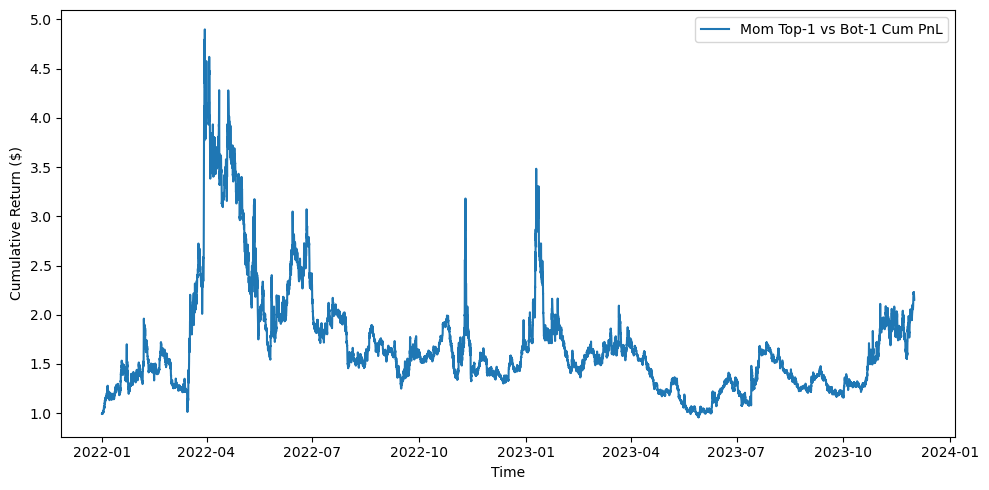

In [10]:
# 8.1) Drop any NaNs (just in case):
mom_backtest = mom_backtest.dropna(subset=['mom_pnl']).reset_index(drop=True)

# 8.2) Compute average hourly return:
avg_hourly_ret = mom_backtest['mom_pnl'].mean()

# 8.3) Compute hourly std:
std_hourly_ret = mom_backtest['mom_pnl'].std(ddof=0)

# 8.4) Annualize (24 hours × 365 days = 8760 hours):
ann_factor = np.sqrt(8760)
sharpe_hourly = (avg_hourly_ret / std_hourly_ret) * ann_factor

# 8.5) Cumulative P&L if you start with \$1:
mom_backtest['cum_pnl'] = (1 + mom_backtest['mom_pnl']).cumprod()

print(f"Momentum‐Factor (top‐1 vs bottom‐1) summary:")
print(f"  Average hourly return    = {avg_hourly_ret:.4%}")
print(f"  Hourly std dev           = {std_hourly_ret:.4%}")
print(f"  Annualized Sharpe (8760h) = {sharpe_hourly:.2f}")
print(f"  Cumulative Return (last) = {mom_backtest['cum_pnl'].iloc[-1]:.2f}  (i.e. × {mom_backtest['cum_pnl'].iloc[-1]:.2f})")

# 8.6) (Optional) Plot the cumulative curve:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(mom_backtest['open_time'], mom_backtest['cum_pnl'], label='Mom Top‐1 vs Bot‐1 Cum PnL')
plt.ylabel("Cumulative Return ($)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# 9.1) For each open_time, compute cross‐sectional Pearson correlation between 'mom_raw' and 'fwd_ret_raw':
def compute_ic(group):
    if group['mom_raw'].std(ddof=0) == 0 or group['fwd_ret_raw'].std(ddof=0) == 0:
        return np.nan
    return group['mom_raw'].corr(group['fwd_ret_raw'])

ic_series = (
    data_df
    .dropna(subset=['mom_raw','fwd_ret_raw'])
    .groupby('open_time')
    .apply(compute_ic)
    .rename('IC')
    .dropna()
    .reset_index()
)

# 9.2) Now summarize:
mean_ic = ic_series['IC'].mean()
tstat_ic = mean_ic / (ic_series['IC'].std(ddof=0) / np.sqrt(len(ic_series)))

print(f"IC summary for momentum factor:")
print(f"  Mean hourly IC = {mean_ic:.4f}")
print(f"  t‐stat         = {tstat_ic:.2f}")


IC summary for momentum factor:
  Mean hourly IC = -0.0205
  t‐stat         = -5.60


/tmp/ipykernel_1064825/3694438003.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_ic)


In [12]:
# Compute vol IC:
def compute_ic_vol(group):
    if group['vol_raw'].std(ddof=0) == 0 or group['fwd_ret_raw'].std(ddof=0) == 0:
        return np.nan
    return group['vol_raw'].corr(group['fwd_ret_raw'])

ic_vol = (
    data_df
    .dropna(subset=['vol_raw','fwd_ret_raw'])
    .groupby('open_time')
    .apply(compute_ic_vol)
    .rename('IC_vol')
    .dropna()
    .reset_index()
)

mean_ic_vol = ic_vol['IC_vol'].mean()
tstat_ic_vol = mean_ic_vol / (ic_vol['IC_vol'].std(ddof=0) / np.sqrt(len(ic_vol)))

print(f"IC summary for volatility factor:")
print(f"  Mean hourly IC_vol = {mean_ic_vol:.4f}")
print(f"  t‐stat            = {tstat_ic_vol:.2f}")


IC summary for volatility factor:
  Mean hourly IC_vol = -0.0156
  t‐stat            = -3.98


/tmp/ipykernel_1064825/1181743372.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_ic_vol)


In [13]:
# Tag for volatility factor:
df_bt_vol = tag_top_bottom(data_df[['open_time','coin_type','vol_cs_z','fwd_ret_raw']].copy(),
                           factor_col='vol_cs_z', top_n=1, bottom_n=1)

# P&L column:
df_bt_vol['vol_pnl'] = (
    df_bt_vol['is_long_vol_cs_z'] * df_bt_vol['fwd_ret_raw']
    - df_bt_vol['is_short_vol_cs_z'] * df_bt_vol['fwd_ret_raw']
)

# Aggregate per hour:
vol_backtest = (
    df_bt_vol
    .groupby('open_time')['vol_pnl']
    .sum()
    .reset_index(name='vol_pnl')
)

# Compute summary stats exactly like we did for momentum:
vol_backtest = vol_backtest.dropna().reset_index(drop=True)
avg_vol_ret  = vol_backtest['vol_pnl'].mean()
std_vol_ret  = vol_backtest['vol_pnl'].std(ddof=0)
sharpe_vol   = (avg_vol_ret / std_vol_ret) * ann_factor
vol_backtest['cum_vol_pnl'] = (1 + vol_backtest['vol_pnl']).cumprod()

print("Volatility‐Factor (top‐1 vs bottom‐1) summary:")
print(f"  Average hourly return    = {avg_vol_ret:.4%}")
print(f"  Hourly std dev           = {std_vol_ret:.4%}")
print(f"  Annualized Sharpe (8760h) = {sharpe_vol:.2f}")
print(f"  Cumulative Return (last) = {vol_backtest['cum_vol_pnl'].iloc[-1]:.2f}")


Volatility‐Factor (top‐1 vs bottom‐1) summary:
  Average hourly return    = 0.0128%
  Hourly std dev           = 1.4013%
  Annualized Sharpe (8760h) = 0.85
  Cumulative Return (last) = 1.67


/tmp/ipykernel_1064825/3082104997.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time', group_keys=False).apply(tag_group)


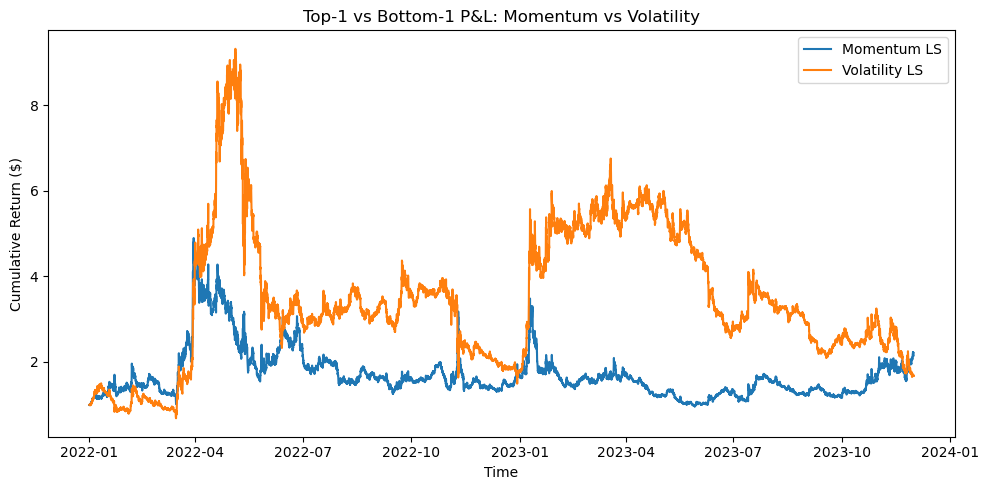

In [14]:
plt.figure(figsize=(10,5))
plt.plot(mom_backtest['open_time'], mom_backtest['cum_pnl'], label='Momentum LS')
plt.plot(vol_backtest['open_time'], vol_backtest['cum_vol_pnl'], label='Volatility LS')
plt.ylabel("Cumulative Return ($)")
plt.xlabel("Time")
plt.legend()
plt.title("Top‐1 vs Bottom‐1 P&L: Momentum vs Volatility")
plt.tight_layout()
plt.show()


# Autoregressive models

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
train_end = pd.to_datetime("2022-12-31 23:00:00")
val_end   = pd.to_datetime("2023-06-30 23:00:00")

is_train = data_df['open_time'] <= train_end
is_val   = (data_df['open_time'] > train_end) & (data_df['open_time'] <= val_end)
is_test  = data_df['open_time'] > val_end

In [16]:
def tag_top_bottom_simple(df, factor_col):
    """
    Given a DataFrame `df` with columns ['open_time','coin_type', factor_col, 'fwd_ret_raw'],
    this function creates two new columns:
      - is_long_<factor_col>  = 1 if coin is top‐1 at that open_time, else 0
      - is_short_<factor_col> = 1 if coin is bottom‐1 at that open_time, else 0
    Returns the augmented DataFrame.
    """
    out = df.copy()
    out[f'is_long_{factor_col}']  = 0
    out[f'is_short_{factor_col}'] = 0

    def tag_group(g):
        # g is all rows at a given open_time
        sorted_g = g.sort_values(by=factor_col, ascending=False)
        if len(sorted_g) < 1:
            return
        top_coin    = sorted_g['coin_type'].iloc[0]
        bottom_coin = sorted_g['coin_type'].iloc[-1]
        out.loc[g.index[g['coin_type'] == top_coin],    f'is_long_{factor_col}']  = 1
        out.loc[g.index[g['coin_type'] == bottom_coin], f'is_short_{factor_col}'] = 1

    df.groupby('open_time',group_keys = False).apply(tag_group)
    return out

# 4) Compute annualized Sharpe on a PnL time‐series
def compute_sharpe(pnl_series):
    """
    Given a pandas Series of hourly PnL values, compute annualized Sharpe
    assuming 8760 trading hours in a year (24 * 365).
    """
    avg_ret = pnl_series.mean()
    std_ret = pnl_series.std(ddof=0)
    if std_ret == 0:
        return np.nan
    return (avg_ret / std_ret) * np.sqrt(8760)

# 5) Backtest factor on a specified period mask
def backtest_factor_in_period(df, factor_col, period_mask):
    """
    df: DataFrame containing at least ['open_time','coin_type', factor_col, 'fwd_ret_raw'].
    period_mask: boolean mask selecting rows (chronologically) for train/validation/test.
    Returns: hourly Sharpe of a long‐short top1 vs bottom1 strategy on factor_col.
    """
    df_period = df.loc[period_mask, ['open_time','coin_type', factor_col, 'fwd_ret_raw']].copy()
    df_bt = tag_top_bottom_simple(df_period, factor_col)
    # Compute PnL: +1 * fwd_return for top‐1, -1 * fwd_return for bottom‐1
    df_bt[f'{factor_col}_pnl'] = (
        df_bt[f'is_long_{factor_col}'] * df_bt['fwd_ret_raw']
      - df_bt[f'is_short_{factor_col}'] * df_bt['fwd_ret_raw']
    )
    # Aggregate per hour
    pnl_ts = df_bt.groupby('open_time')[f'{factor_col}_pnl'].sum()
    return compute_sharpe(pnl_ts)

# 6) ARIMA & GARCH helper functions
def fit_arima_and_forecast(arr: np.ndarray, order: tuple) -> float:
    """
    arr: 1D NumPy array length L_mom, containing hourly returns with no NaNs.
    Fit ARIMA(order) on arr, return 1‐step‐ahead forecast. If failure, return NaN.
    """

    series = pd.Series(arr).astype('float64').dropna()
    if len(series) < len(arr):
        return np.nan
    model = ARIMA(series, order=order)
    res = model.fit(method = "innovations_mle")
    forecast = res.forecast(steps=1)
    return float(forecast.iloc[0])


def compute_mom_arima_z(df, L_mom, arima_order):
    """
    1) Computes a rolling‐window ARIMA(L_mom) 1‐step forecast on each coin’s returns.
    2) Cross‐sectionally z‐scores that forecast at each timestamp.
    Returns: name of the new column storing z‐scored forecast.
    """
    col_raw = f'mom_arima_raw_{L_mom}_{arima_order[0]}{arima_order[1]}{arima_order[2]}'
    df[col_raw] = (
        df
        .groupby('coin_type')['return']
        .transform(lambda r: 
            r.rolling(window=L_mom, min_periods=L_mom)
             .apply(lambda arr: fit_arima_and_forecast(arr, order=arima_order), raw=True)
        )
    )
    col_z = f'mom_arima_z_{L_mom}_{arima_order[0]}{arima_order[1]}{arima_order[2]}'
    df[col_z] = (
        df
        .groupby('open_time')[col_raw]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )
    return col_z

def fit_garch_and_get_cond_vol(r: pd.Series, p, q, dist):
    """
    Fit GARCH(p,q,dist) on r*100 (percent) and return conditional volatility (in decimal)
    aligned to r.index. If failure, return NaNs.
    """
    r_clean = (r.dropna() * 100).astype('float64')
    if len(r_clean) < max(30, p+q):
        return pd.Series(index=r.index, data=np.nan)

    am = arch_model(r_clean, vol='GARCH', p=p, q=q, dist=dist)
    res = am.fit(disp='off')
    cond_vol_pct = res.conditional_volatility
    cond_vol = cond_vol_pct / 100.0
    out = pd.Series(index=r.index, dtype='float64')
    out.loc[r_clean.index] = cond_vol.values
    return out.ffill()


def compute_vol_garch_z(df, p, q, dist):
    """
    1) Computes GARCH(p,q,dist) conditional vol on each coin’s return series.
    2) Cross‐sectionally z‐scores at each timestamp.
    Returns: name of the new column storing z‐scored vol.
    """
    col_raw = f'vol_garch_raw_{p}{q}_{dist}'
    df[col_raw] = (
        df
        .groupby('coin_type')['return']
        .transform(lambda r: fit_garch_and_get_cond_vol(r, p=p, q=q, dist=dist))
    )
    col_z = f'vol_garch_z_{p}{q}_{dist}'
    df[col_z] = (
        df
        .groupby('open_time')[col_raw]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )
    return col_z


In [17]:
# L_mom_values = [24, 48, 72]
# arima_orders = [(1,0,0), (1,1,0), (2,0,0)]
# garch_params = [(1,1,'normal'), (1,2,'t'), (2,1,'t')]

L_mom_values = [24]
arima_orders = [(1,0,0)]
garch_params = [(1,1,'normal')]

In [18]:
mom_results = []
for L in L_mom_values:
    for order in arima_orders:
        factor_col = compute_mom_arima_z(data_df, L, order)
        valid_mask = ~data_df[factor_col].isna()
        sharpe_val = backtest_factor_in_period(data_df.loc[valid_mask], factor_col, is_val.loc[valid_mask])
        mom_results.append({'L_mom': L, 'arima_order': order, 'factor_col': factor_col, 'sharpe_val': sharpe_val})

mom_results_df = pd.DataFrame(mom_results)
best_mom_row = mom_results_df.loc[mom_results_df['sharpe_val'].idxmax()]
best_mom_factor = best_mom_row['factor_col']

/tmp/ipykernel_1064825/3119051938.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time',group_keys = False).apply(tag_group)


In [19]:
vol_results = []
for p, q, dist in garch_params:
    factor_col = compute_vol_garch_z(data_df, p, q, dist)
    valid_mask = ~data_df[factor_col].isna()
    sharpe_val = backtest_factor_in_period(data_df.loc[valid_mask], factor_col, is_val.loc[valid_mask])
    vol_results.append({'garch_p': p, 'garch_q': q, 'garch_dist': dist, 'factor_col': factor_col, 'sharpe_val': sharpe_val})

vol_results_df = pd.DataFrame(vol_results)
best_vol_row = vol_results_df.loc[vol_results_df['sharpe_val'].idxmax()]
best_vol_factor = best_vol_row['factor_col']

/tmp/ipykernel_1064825/3119051938.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time',group_keys = False).apply(tag_group)


In [20]:
data_df[best_mom_factor] = compute_mom_arima_z(data_df, int(best_mom_row['L_mom']), tuple(best_mom_row['arima_order']))
data_df[best_vol_factor] = compute_vol_garch_z(data_df, int(best_vol_row['garch_p']), int(best_vol_row['garch_q']), best_vol_row['garch_dist'])

# Drop rows with NaN best factors
valid_final = ~data_df[best_mom_factor].isna() & ~data_df[best_vol_factor].isna()
data_df = data_df.loc[valid_final].reset_index(drop=True)
is_test_final = is_test.loc[valid_final]


In [21]:

# 9) Build PnL time series on TEST for both factors
# Momentum PnL
df_mom_test = data_df[['open_time','coin_type', best_mom_factor, 'fwd_ret_raw']].copy()
df_mom_test = tag_top_bottom_simple(df_mom_test, best_mom_factor)
df_mom_test[f'{best_mom_factor}_pnl'] = (
    df_mom_test[f'is_long_{best_mom_factor}'] * df_mom_test['fwd_ret_raw']
  - df_mom_test[f'is_short_{best_mom_factor}'] * df_mom_test['fwd_ret_raw']
)
mom_pnl_ts = df_mom_test[df_mom_test['open_time'].isin(data_df.loc[is_test_final, 'open_time'])] \
                .groupby('open_time')[f'{best_mom_factor}_pnl'].sum()

# Volatility PnL
df_vol_test = data_df[['open_time','coin_type', best_vol_factor, 'fwd_ret_raw']].copy()
df_vol_test = tag_top_bottom_simple(df_vol_test, best_vol_factor)
df_vol_test[f'{best_vol_factor}_pnl'] = (
    df_vol_test[f'is_long_{best_vol_factor}'] * df_vol_test['fwd_ret_raw']
  - df_vol_test[f'is_short_{best_vol_factor}'] * df_vol_test['fwd_ret_raw']
)
vol_pnl_ts = df_vol_test[df_vol_test['open_time'].isin(data_df.loc[is_test_final, 'open_time'])] \
                .groupby('open_time')[f'{best_vol_factor}_pnl'].sum()

# 10) Compute cumulative returns: start from 1
cum_mom = (1 + mom_pnl_ts).cumprod()
cum_vol = (1 + vol_pnl_ts).cumprod()

/tmp/ipykernel_1064825/3119051938.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time',group_keys = False).apply(tag_group)
/tmp/ipykernel_1064825/3119051938.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('open_time',group_keys = False).apply(tag_group)


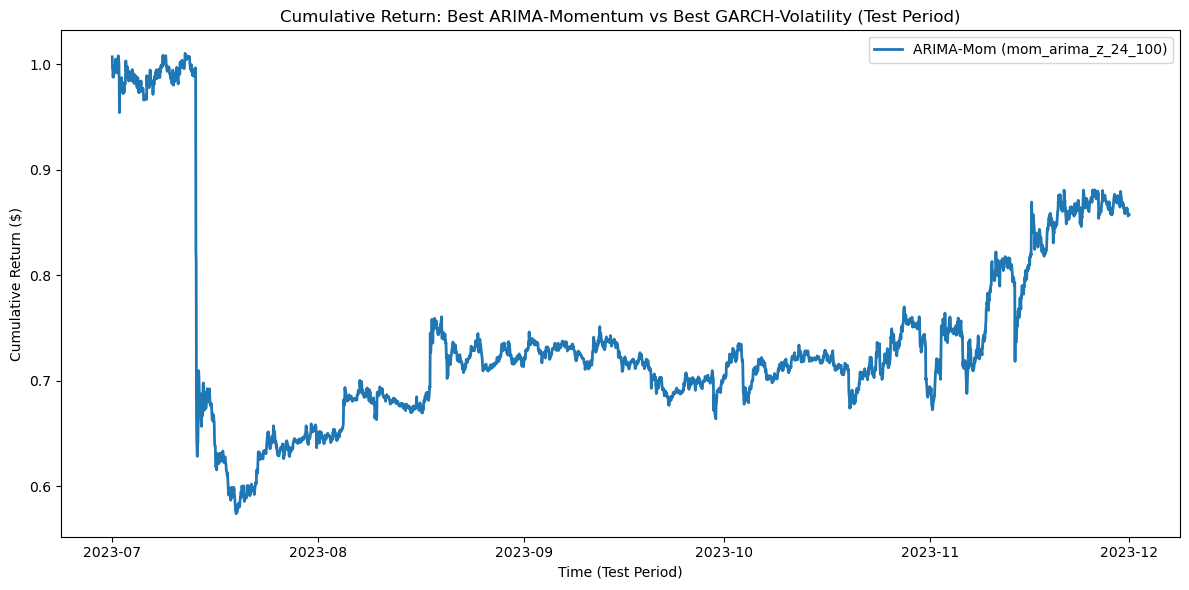

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(cum_mom.index, cum_mom.values, label=f'ARIMA‐Mom ({best_mom_factor})', linewidth=2)
#plt.plot(cum_vol.index, cum_vol.values, label=f'GARCH‐Vol ({best_vol_factor})', linewidth=2)
plt.xlabel('Time (Test Period)')
plt.ylabel('Cumulative Return ($)')
plt.title('Cumulative Return: Best ARIMA‐Momentum vs Best GARCH‐Volatility (Test Period)')
plt.legend()
plt.tight_layout()
plt.show()

# Stationary test

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:

# Optionally, also test on log-price levels to confirm non-stationarity of price
results_lp = []
data_df['log_close'] = np.log(data_df['close'])
for coin, grp in data_df.groupby('coin_type'):
    logp = grp['log_close'].dropna()
    adf_res_lp = adfuller(logp)
    results_lp.append({
        'coin_type': coin,
        'adf_statistic_logprice': adf_res_lp[0],
        'p_value_logprice':       adf_res_lp[1],
        'used_lag_logprice':      adf_res_lp[2],
        'n_obs_logprice':         adf_res_lp[3]
    })

df_stationarity_lp = pd.DataFrame(results_lp)
display(df_stationarity_lp)

,coin_type,adf_statistic_logprice,p_value_logprice,used_lag_logprice,n_obs_logprice
0,ADA,-2.471961,0.122446,31,16743
1,BNB,-2.775199,0.061905,39,16639
2,BTC,-1.798967,0.380975,0,16678
3,ETH,-2.643962,0.084247,32,16742
4,GALA,-2.540100,0.106020,44,16682
5,GMT,-1.245533,0.653709,39,14931
6,LINK,-2.275919,0.179852,26,16748
7,MATIC,-2.830012,0.054113,31,16743
8,SOL,-2.409661,0.139028,33,16621
9,XRP,-2.327841,0.163146,31,16623


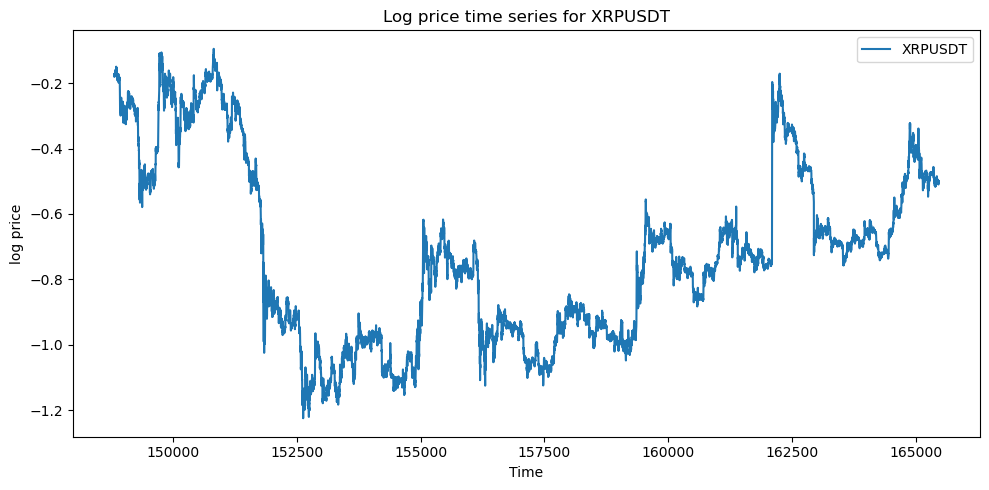

In [25]:
plt.figure(figsize=(10,5))
plt.plot(logp.index,logp.values, label='XRPUSDT')
plt.ylabel("log price")
plt.xlabel("Time")
plt.legend()
plt.title("Log price time series for XRPUSDT")
plt.tight_layout()
plt.show()


In [26]:
results = []
for coin, grp in data_df.groupby('coin_type'):
    returns = grp['return'].dropna()
    # Run ADF test
    adf_res = adfuller(returns)
    results.append({
        'coin_type': coin,
        'adf_statistic': adf_res[0],
        'p_value':       adf_res[1],
        'used_lag':      adf_res[2],
        'n_obs':         adf_res[3]
    })

df_stationarity = pd.DataFrame(results)
display(df_stationarity)


,coin_type,adf_statistic,p_value,used_lag,n_obs
0,ADA,-25.432659,0.000000e+00,30,16744
1,BNB,-21.573747,0.000000e+00,38,16640
2,BTC,-130.116778,0.000000e+00,0,16678
3,ETH,-18.189403,2.421480e-30,44,16730
4,GALA,-18.383406,2.207275e-30,44,16682
5,GMT,-17.368786,5.152325e-30,42,14928
6,LINK,-25.985164,0.000000e+00,25,16749
7,MATIC,-24.319323,0.000000e+00,30,16744
8,SOL,-23.585505,0.000000e+00,32,16622
9,XRP,-25.102087,0.000000e+00,30,16624


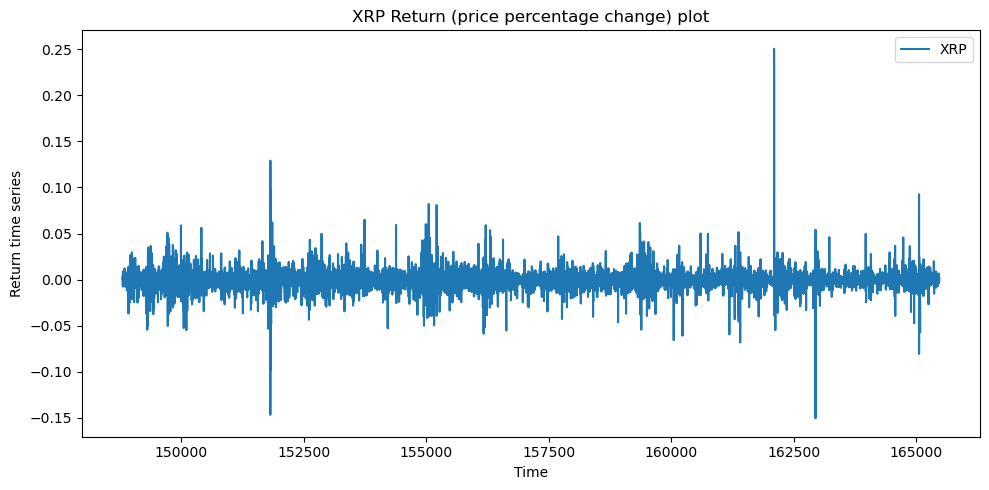

In [27]:
plt.figure(figsize=(10,5))
plt.plot(returns.index,returns.values, label='XRP')
plt.ylabel("Return time series")
plt.xlabel("Time")
plt.legend()
plt.title("XRP Return (price percentage change) plot")
plt.tight_layout()
plt.show()


## Mean-reversion

/tmp/ipykernel_1064825/431870362.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mr1 = df_mr1.groupby('open_time').apply(normalize_weights).reset_index(drop=True)


=== One‐Lag Mean‐Reversion ===
Avg hourly ret = 0.0026%
Std hourly ret = 0.6687%
Ann Sharpe     = 0.37
Final cum PnL  = 1.06


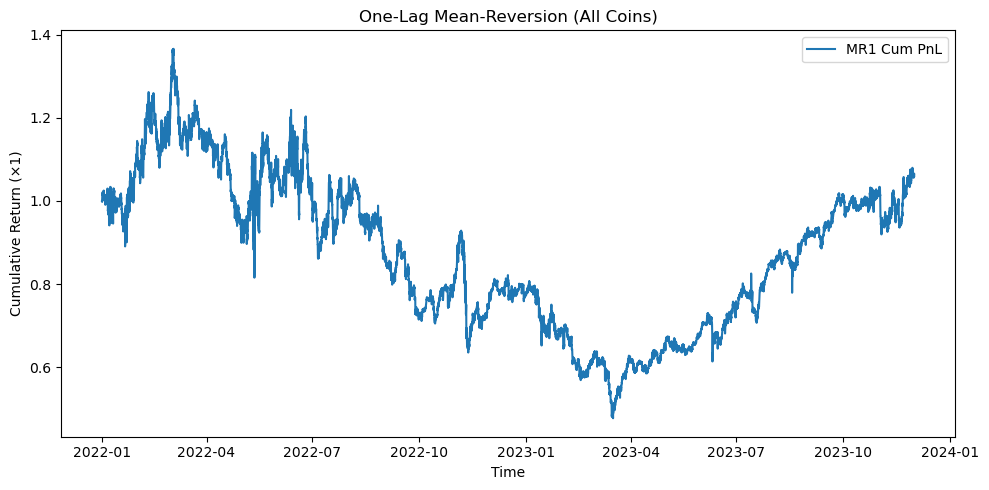

In [37]:
data_df['open_time'] = pd.to_datetime(data_df['open_time'])
# Compute hourly simple return:
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda s: s.pct_change())
)
# Drop NaNs (first row per coin)
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

# ──────────────────────────────────────────────────────────
# 1) One‐Lag Mean‐Reversion
# ──────────────────────────────────────────────────────────
# 1.1) Lagged return:
data_df['r_lag1'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda x: x.shift(1))
)
# 1.2) Signal = -sign(r_lag1)
data_df['signal_mr1'] = data_df['r_lag1'].apply(lambda x: -np.sign(x) if pd.notna(x) else 0)

# 1.3) Normalize weights per hour:
def normalize_weights(df):
    nonzero = (df['signal_mr1'] != 0).sum()
    out = df.copy()
    if nonzero > 0:
        out['weight_mr1'] = df['signal_mr1'] / nonzero
    else:
        out['weight_mr1'] = 0.0
    return out

df_mr1 = data_df.copy().reset_index(drop=True)
df_mr1 = df_mr1.groupby('open_time').apply(normalize_weights).reset_index(drop=True)

# 1.4) P&L = weight * return
df_mr1['pnl_mr1'] = df_mr1['weight_mr1'] * df_mr1['return']

# 1.5) Aggregate to get portfolio P&L per hour
backtest_mr1 = (
    df_mr1
    .groupby('open_time')['pnl_mr1']
    .sum()
    .reset_index(name='pnl_mr1')
)
backtest_mr1 = backtest_mr1.dropna(subset=['pnl_mr1']).reset_index(drop=True)

# 1.6) Stats for MR1
avg_ret_mr1   = backtest_mr1['pnl_mr1'].mean()
std_ret_mr1   = backtest_mr1['pnl_mr1'].std(ddof=0)
ann_sharpe_mr1 = (avg_ret_mr1 / std_ret_mr1) * np.sqrt(8760)
backtest_mr1['cum_pnl_mr1'] = (1 + backtest_mr1['pnl_mr1']).cumprod()

print("=== One‐Lag Mean‐Reversion ===")
print(f"Avg hourly ret = {avg_ret_mr1:.4%}")
print(f"Std hourly ret = {std_ret_mr1:.4%}")
print(f"Ann Sharpe     = {ann_sharpe_mr1:.2f}")
print(f"Final cum PnL  = {backtest_mr1['cum_pnl_mr1'].iloc[-1]:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(backtest_mr1['open_time'], backtest_mr1['cum_pnl_mr1'], label='MR1 Cum PnL')
plt.title('One‐Lag Mean‐Reversion (All Coins)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (×1)')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_1064825/1206053214.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extreme = df_extreme.groupby('open_time').apply(tag_extremes).reset_index(drop=True)
/tmp/ipykernel_1064825/1206053214.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_extreme = df_extreme.groupby('open_time').apply(assign_weights).reset_index(drop=True)


=== “Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion ===
Average hourly return  = 0.0006%
Std dev of hourly ret  = 0.0826%
Annualized Sharpe      = 0.74
Final cumulative P&L   = 1.11


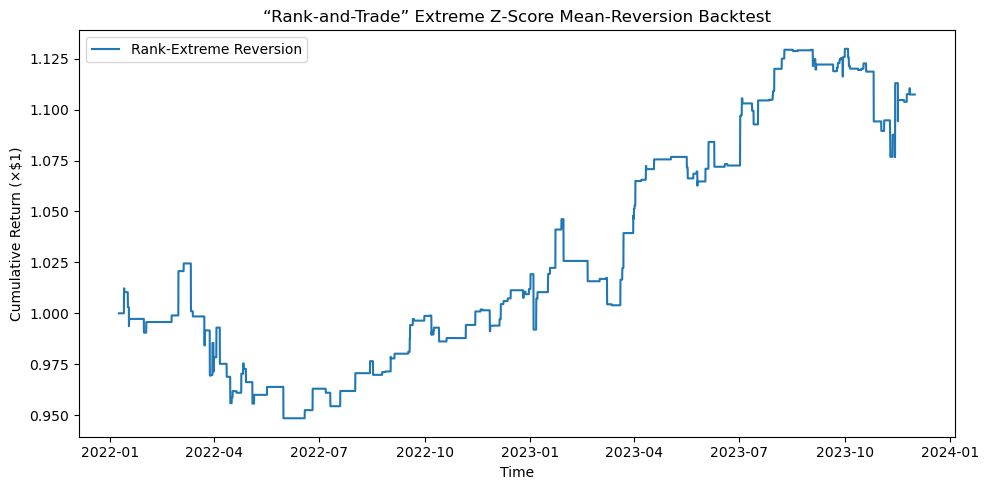

In [51]:
# 1) Compute simple hourly return per coin:
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .transform(lambda s: s.pct_change())
)

# 2) Drop the first NaN‐return for each coin
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# B) COMPUTE ROLLING STD (σ_{i,t-1}) and LAGGED return (r_{i,t-1})
# ──────────────────────────────────────────────────────────
L = 24     # look‐back window for rolling‐sigma
theta = 1.5  # z‐score threshold

# 1) Rolling‐window mean and std of returns (we only really need std since mean ~ 0)
data_df['r_std_L'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda r: r.rolling(window=L, min_periods=L).std())
)

# 2) Lag those stats by one hour, so that at time t we only use info up to t−1
data_df['r_std_L_lag1'] = (
    data_df
    .groupby('coin_type')['r_std_L']
    .transform(lambda s: s.shift(1))
)

# 3) Lagged return itself
data_df['r_lag1'] = (
    data_df
    .groupby('coin_type')['return']
    .transform(lambda s: s.shift(1))
)

# 4) Compute z‐score of the last hour’s return, using σ_{t-1}:
data_df['z_lag1'] = data_df['r_lag1'] / data_df['r_std_L_lag1']

# 5) We’ll drop any row where σ_{t-1} is NaN (i.e. we don’t have a full L‐hour history yet)
data_df = data_df.dropna(subset=['r_std_L_lag1']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# C) TAG “MOST EXTREME” COINS AND BUILD LONG/SHORT SIGNALS
# ──────────────────────────────────────────────────────────

df_extreme = data_df[['open_time','coin_type','z_lag1','return']].copy()

# Initialize columns for “is_long_extreme” and “is_short_extreme”
df_extreme['is_long_extreme']  = 0
df_extreme['is_short_extreme'] = 0

def tag_extremes(group):
    """
    Input: group = all coins at a fixed open_time t
    We find the coin with the minimum z_lag1 and the coin with the maximum z_lag1.
    If z_min < -theta AND z_max > +theta, we set:
       is_long_extreme  = 1  for the coin that has z_min,
       is_short_extreme = 1  for the coin that has z_max.
    Otherwise, we leave both as 0 (no trade).
    """
    # 1) Identify index of smallest and largest z_lag1
    idx_min = group['z_lag1'].idxmin()
    idx_max = group['z_lag1'].idxmax()

    z_min = group.loc[idx_min, 'z_lag1']
    z_max = group.loc[idx_max, 'z_lag1']

    # 2) Check thresholds
    if (z_min < -theta) and (z_max > +theta):
        group.at[idx_min, 'is_long_extreme']  = 1
        group.at[idx_max, 'is_short_extreme'] = 1
    # else: leave both at 0 (no trade)

    return group

# Apply per open_time
df_extreme = df_extreme.groupby('open_time').apply(tag_extremes).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# D) ASSIGN WEIGHTS AND COMPUTE NEXT‐HOUR P&L
# ──────────────────────────────────────────────────────────

# 1) Create a column for weight_extreme; default to 0
df_extreme['weight_extreme'] = 0.0

def assign_weights(group):
    """
    At each open_time, group will have ten rows (one per coin).
    Exactly one row may have is_long_extreme=1, 
    exactly one row may have is_short_extreme=1 (or both zero).
    We assign weight +0.5 to the long coin, -0.5 to the short coin.
    If no signals, all weights = 0.
    """
    # Find how many longs and shorts:
    n_long  = (group['is_long_extreme']  == 1).sum()
    n_short = (group['is_short_extreme'] == 1).sum()

    # If exactly one long and one short, assign 0.5 and -0.5:
    if (n_long == 1) and (n_short == 1):
        group.loc[group['is_long_extreme'] == 1,  'weight_extreme'] = +0.5
        group.loc[group['is_short_extreme'] == 1, 'weight_extreme'] = -0.5
    else:
        # no trade or incomplete signal → all zeros
        group['weight_extreme'] = 0.0

    return group

df_extreme = df_extreme.groupby('open_time').apply(assign_weights).reset_index(drop=True)

# 2) Compute the P&L at time t as: weight_extreme * return_{i,t}
#    Because we enter at t (based on last‐hour’s z) and exit at t+1, using "return" 
#    is appropriate if return_{i,t} = (P_{i,t}/P_{i,t-1}) - 1. 
#    In our load, data_df['return'] is indeed that.
df_extreme['pnl_extreme'] = df_extreme['weight_extreme'] * df_extreme['return']

# 3) Collapse to get one P&L per open_time
backtest_extreme = (
    df_extreme
    .groupby('open_time')['pnl_extreme']
    .sum()
    .reset_index(name='pnl_extreme')
).dropna(subset=['pnl_extreme']).reset_index(drop=True)


# ──────────────────────────────────────────────────────────
# E) SUMMARY STATS & PLOT
# ──────────────────────────────────────────────────────────
avg_ret_extreme = backtest_extreme['pnl_extreme'].mean()
std_ret_extreme = backtest_extreme['pnl_extreme'].std(ddof=0)
ann_sharpe_extreme = (avg_ret_extreme / std_ret_extreme) * np.sqrt(8760)
backtest_extreme['cum_pnl_extreme'] = (1 + backtest_extreme['pnl_extreme']).cumprod()

print("=== “Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion ===")
# print(f"Threshold (θ)          = {theta}")
# print(f"Look‐back window (L)   = {L} hours")
print(f"Average hourly return  = {avg_ret_extreme:.4%}")
print(f"Std dev of hourly ret  = {std_ret_extreme:.4%}")
print(f"Annualized Sharpe      = {ann_sharpe_extreme:.2f}")
print(f"Final cumulative P&L   = {backtest_extreme['cum_pnl_extreme'].iloc[-1]:.2f}")

# Plot cumulative curve
plt.figure(figsize=(10,5))
plt.plot(backtest_extreme['open_time'], backtest_extreme['cum_pnl_extreme'], label='Rank‐Extreme Reversion')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (×$1)')
plt.title('“Rank‐and‐Trade” Extreme Z‐Score Mean‐Reversion Backtest')
plt.legend()
plt.tight_layout()
plt.show()

# Cointegration test

In [28]:
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## CADF test

In [29]:
price_df = data_df.pivot(index='open_time', columns='coin_type', values='close')

# 2) Identify all unique pairs of coins
coins = price_df.columns.tolist()
pairs = []
for i in range(len(coins)):
    for j in range(i+1, len(coins)):
        pairs.append((coins[i], coins[j]))

# 3) For each pair, run Engle-Granger (CADF) test and record ADF p-value
results = []
for coin1, coin2 in pairs:
    pair_df = price_df[[coin1, coin2]].dropna()
    if len(pair_df) < 50:
        # Not enough data points
        continue

    # OLS regression: coin1 ~ coin2
    y = pair_df[coin1]
    x = pair_df[coin2]
    x_const = sm.add_constant(x)
    ols_res = sm.OLS(y, x_const).fit()
    beta_hat = ols_res.params[coin2]
    resid = ols_res.resid

    # ADF on residuals
    adf_stat, adf_pval, _, _, crit_vals, _ = adfuller(resid.dropna())
    results.append({
        "pair" : f"{coin1}-{coin2}",
        'coin1': coin1,
        'coin2': coin2,
        'beta_hat': beta_hat,
        'adf_stat': adf_stat,
        'adf_pval': adf_pval,
        'crit_1%': crit_vals['1%'],
        'crit_5%': crit_vals['5%'],
        'crit_10%': crit_vals['10%']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('adf_pval')
results_df = results_df.reset_index(drop=True)

In [30]:
results_df[:3]

,pair,coin1,coin2,beta_hat,adf_stat,adf_pval,crit_1%,crit_5%,crit_10%
0,GALA-GMT,GALA,GMT,0.059660,-5.646766,0.000001,-3.430789,-2.861734,-2.566873
1,ADA-GALA,ADA,GALA,3.023319,-5.468280,0.000002,-3.430742,-2.861713,-2.566862
2,ADA-GMT,ADA,GMT,0.231038,-4.021515,0.001302,-3.430788,-2.861734,-2.566873


Top cointegrated pair: GALA & GMT (ADF p-value = 0.0000)


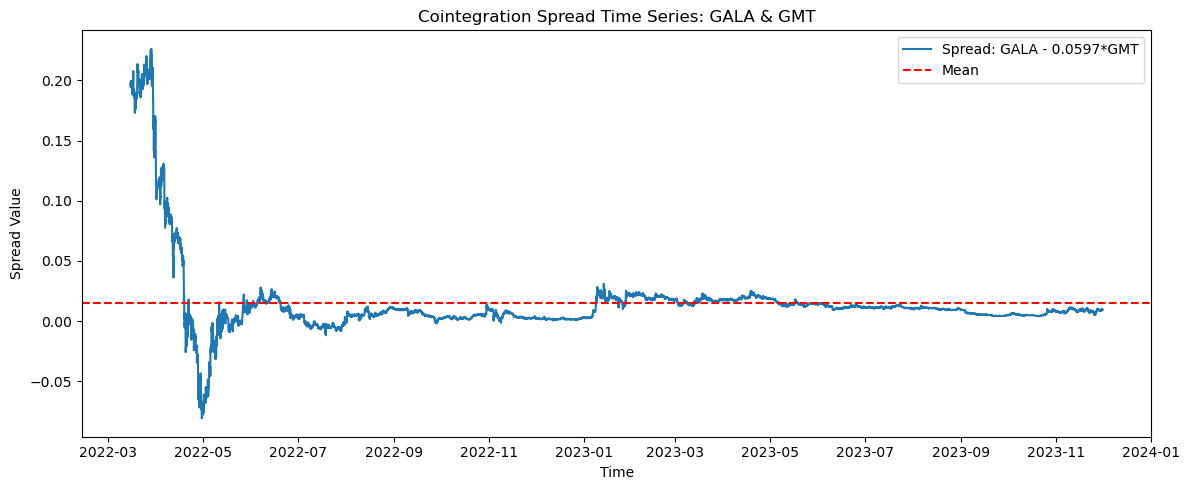

In [31]:
best_pair = results_df.iloc[0]
coin1 = best_pair['coin1']
coin2 = best_pair['coin2']
beta_hat = best_pair['beta_hat']
best_pval = best_pair['adf_pval']

print(f"Top cointegrated pair: {coin1} & {coin2} (ADF p-value = {best_pval:.4f})")

# 5) Compute the spread: S_t = Y_t - beta_hat * X_t
pair_df = price_df[[coin1, coin2]].dropna()
spread = pair_df[coin1] - beta_hat * pair_df[coin2]

# 6) Plot the spread time series
plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread.values, label=f"Spread: {coin1} - {beta_hat:.4f}*{coin2}")
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.title(f"Cointegration Spread Time Series: {coin1} & {coin2}")
plt.legend()
plt.tight_layout()
plt.show()

## Johansen’s test

In [32]:
coins = price_df.columns.tolist()
pairs = []
for i in range(len(coins)):
    for j in range(i+1, len(coins)):
        pairs.append((coins[i], coins[j]))

# 3) For each pair, run Johansen’s test and record the “trace statistic minus 95% critical value” for r=0
joh_results = []
for coin1, coin2 in pairs:
    pair_df = price_df[[coin1, coin2]].dropna()
    if len(pair_df) < 50:
        continue
    
    # Perform Johansen test (det_order=0, k_ar_diff=1)
    jres = coint_johansen(pair_df.values, det_order=0, k_ar_diff=1)
    trace_stat_0 = jres.lr1[0]            # Trace statistic for r=0
    crit_95_0 = jres.cvt[0, 1]            # 95% critical value for r=0
    margin = trace_stat_0 - crit_95_0     # how much trace exceeds critical
    
    joh_results.append({
        'coin1': coin1,
        'coin2': coin2,
        'trace_stat_0': trace_stat_0,
        'crit_95_0': crit_95_0,
        'margin': margin,
        'eigvec_b1': jres.evec[0, 0],
        'eigvec_b2': jres.evec[1, 0]
    })

joh_df = pd.DataFrame(joh_results)

Top Johansen cointegrated pair: GALA & GMT (margin = 68.4966)


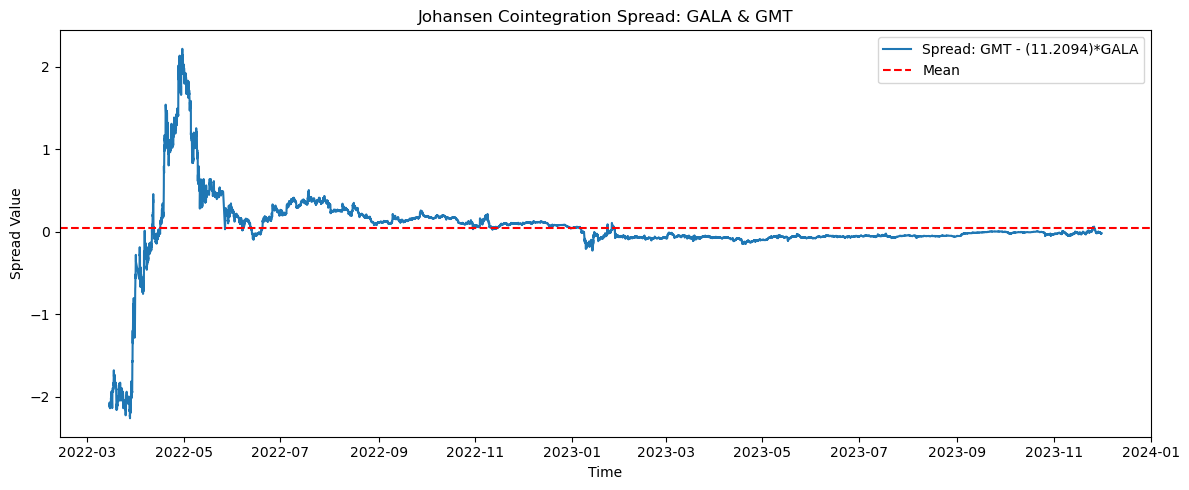

In [33]:
best_joh_row = joh_df.loc[joh_df['margin'].idxmax()]
coin1 = best_joh_row['coin1']
coin2 = best_joh_row['coin2']
b1 = best_joh_row['eigvec_b1']
b2 = best_joh_row['eigvec_b2']
margin = best_joh_row['margin']

print(f"Top Johansen cointegrated pair: {coin1} & {coin2} (margin = {margin:.4f})")

# 5) Compute the spread: if eigenvector is [b1, b2], coin2 = -(b1/b2)*coin1
alpha = -b1 / b2
pair_df = price_df[[coin1, coin2]].dropna()
spread = pair_df[coin2] - alpha * pair_df[coin1]

# 6) Plot the spread time series
plt.figure(figsize=(12, 5))
plt.plot(spread.index, spread.values, label=f"Spread: {coin2} - ({alpha:.4f})*{coin1}")
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.xlabel("Time")
plt.ylabel("Spread Value")
plt.title(f"Johansen Cointegration Spread: {coin1} & {coin2}")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
joh_df = joh_df.sort_values('margin',ascending=False)
joh_df = joh_df.reset_index(drop=True)
joh_df[:3]

,coin1,coin2,trace_stat_0,crit_95_0,margin,eigvec_b1,eigvec_b2
0,GALA,GMT,83.990854,15.4943,68.496554,25.633936,-2.286821
1,ADA,GMT,58.039788,15.4943,42.545488,8.203502,-2.476805
2,ADA,GALA,56.609590,15.4943,41.115290,9.942601,-37.705094


## Mean reversion strategy

In [35]:
top3 = results_df.head(3).reset_index(drop=True)
start_date = pd.to_datetime("2022-06-01 00:00:00")
df_post_june = data_df[data_df['open_time'] >= start_date].copy()
price_df_post_june = df_post_june.pivot(index='open_time', columns='coin_type', values='close')



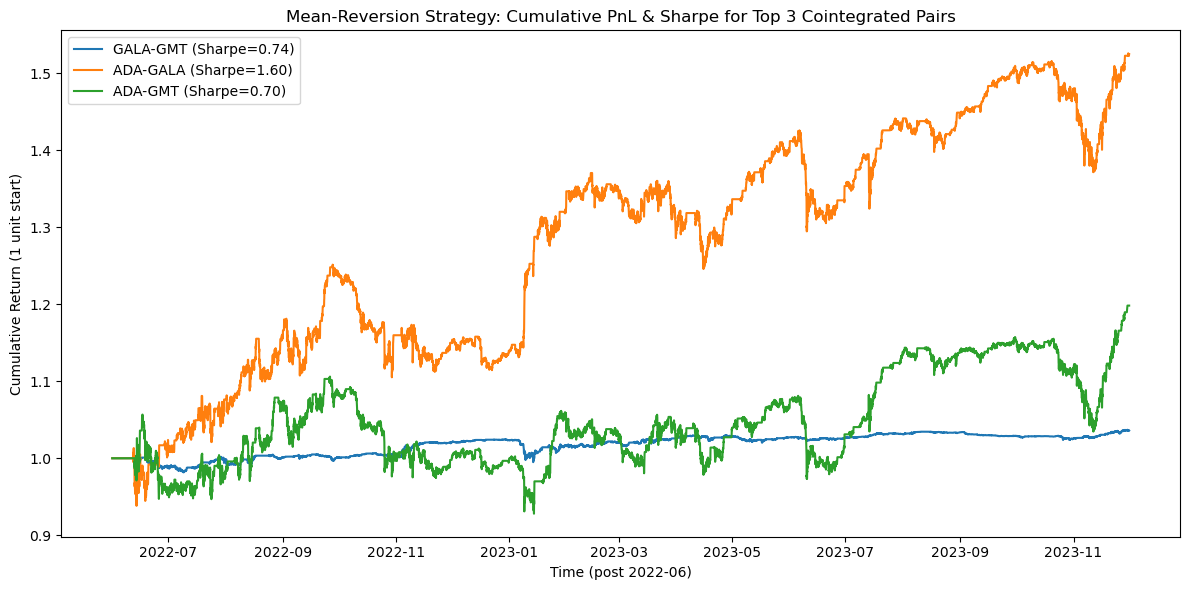

Sharpe Ratios for Top 3 Pairs:
GALA-GMT: 0.74
ADA-GALA: 1.60
ADA-GMT: 0.70


In [36]:
coins = price_df_post_june.columns.tolist()
pairs = [(coins[i], coins[j]) for i in range(len(coins)) for j in range(i+1, len(coins))]

results = {}
window = 252  # rolling window of 252 hours (~10.5 days)

for idx, row in top3.iterrows():
    coin1 = row['coin1']
    coin2 = row['coin2']
    beta = row['beta_hat']
    pair_price = price_df_post_june[[coin1, coin2]].dropna()

    # Compute spread S_t = coin1 - beta * coin2
    spread = pair_price[coin1] - beta * pair_price[coin2]

    # Rolling mean and std of spread
    roll_mean = spread.rolling(window=window, min_periods=window).mean()
    roll_std = spread.rolling(window=window, min_periods=window).std()

    # Z-score
    z_score = (spread - roll_mean) / roll_std

    # Generate signals: long spread if z < -1, short if z > 1, exit at z between -0.5 and 0.5
    signal = pd.Series(index=z_score.index, data=0)
    position = 0
    for t in z_score.index:
        zt = z_score.loc[t]
        if position == 0:
            if zt > 1:
                position = -1  # short spread
            elif zt < -1:
                position = 1   # long spread
        elif position == 1 and zt >= 0:
            position = 0
        elif position == -1 and zt <= 0:
            position = 0
        signal.loc[t] = position

    # Compute PnL: PnL_t = position_{t-1} * (S_t - S_{t-1})
    delta_spread = spread.diff()
    pnl = signal.shift(1).fillna(0) * delta_spread
    cum_pnl = (1 + pnl.fillna(0)).cumprod()

    # Compute Sharpe ratio (annualized, 8760 hours)
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    sharpe = (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan

    results[f"{coin1}-{coin2}"] = {
        'spread': spread,
        'z_score': z_score,
        'signal': signal,
        'pnl': pnl,
        'cum_pnl': cum_pnl,
        'sharpe': sharpe
    }

# 6) Plot cumulative PnL for top 3 pairs and display Sharpe ratios
plt.figure(figsize=(12, 6))
for pair_name, data in results.items():
    plt.plot(data['cum_pnl'].index, data['cum_pnl'].values, label=f"{pair_name} (Sharpe={data['sharpe']:.2f})", linewidth=1.5)
plt.xlabel("Time (post 2022-06)")
plt.ylabel("Cumulative Return (1 unit start)")
plt.title("Mean-Reversion Strategy: Cumulative PnL & Sharpe for Top 3 Cointegrated Pairs")
plt.legend()
plt.tight_layout()
plt.show()

# 7) Print Sharpe ratios
print("Sharpe Ratios for Top 3 Pairs:")
for pair_name, data in results.items():
    print(f"{pair_name}: {data['sharpe']:.2f}")